# Energy Consumption Prediction Using LSTM 
in this code we aim to predict the energy consumption using long short term memory . the process involve data preprocessing,building and training the model , finally evaluating the performance 

## Steps 

- **Data Loading and Preprocessing**: Load the data using `pandas`, apply `MinMaxScaler` normalization, and prepare a sequence-based dataset for LSTM.
- **LSTM Model Definition**: Define the LSTM model structure, including the number of layers, neurons, and other configurations.
- **Model Training**: Train the model over a set number of epochs while recording both training and validation loss.
- **Evaluation and Visualization**: Evaluate the model's performance and visualize the results.


In [165]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from skimpy import skim
import statsmodels.api as sm

In [166]:
df=pd.read_csv('../datasets/d5.csv')

In [167]:
print(df.describe)

<bound method NDFrame.describe of             Date  Energy Consumption
0     2020-01-01          305.311409
1     2020-01-02          299.374329
2     2020-01-03          307.646359
3     2020-01-04          316.811967
4     2020-01-05          299.651923
...          ...                 ...
1455  2023-12-26          380.398916
1456  2023-12-27          405.951747
1457  2023-12-28          402.642110
1458  2023-12-29          412.140555
1459  2023-12-30          406.387546

[1460 rows x 2 columns]>


In [168]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1460   │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50  ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Energy Consumption     │   0 │     0 │  350.5 │  31.57 │  265.9 │  324.9 │  350 │  375.6 │  424.2 │  ▅▇▇▇▂ │  │
│ └────────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴──────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Date                      │       0 │          0 │                            1 │                     1460 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [169]:
df.isna().sum()

Date                  0
Energy Consumption    0
dtype: int64

In [170]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour  # Assuming timestamps are present, otherwise this will be 0
df['Weekday'] = df['Date'].dt.weekday  # 0 = Monday, 6 = Sunday
df['Season'] = df['Date'].dt.month % 12 // 3 + 1  # Rough estimate for seasons

season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(season_map)


In [171]:
print(df['Season'].unique())

['Winter' 'Spring' 'Summer' 'Fall']


In [172]:
df

,Date,Energy Consumption,Year,Month,Day,Hour,Weekday,Season
0,2020-01-01,305.311409,2020,1,1,0,2,Winter
1,2020-01-02,299.374329,2020,1,2,0,3,Winter
2,2020-01-03,307.646359,2020,1,3,0,4,Winter
3,2020-01-04,316.811967,2020,1,4,0,5,Winter
4,2020-01-05,299.651923,2020,1,5,0,6,Winter
...,...,...,...,...,...,...,...,...
1455,2023-12-26,380.398916,2023,12,26,0,1,Winter
1456,2023-12-27,405.951747,2023,12,27,0,2,Winter
1457,2023-12-28,402.642110,2023,12,28,0,3,Winter
1458,2023-12-29,412.140555,2023,12,29,0,4,Winter


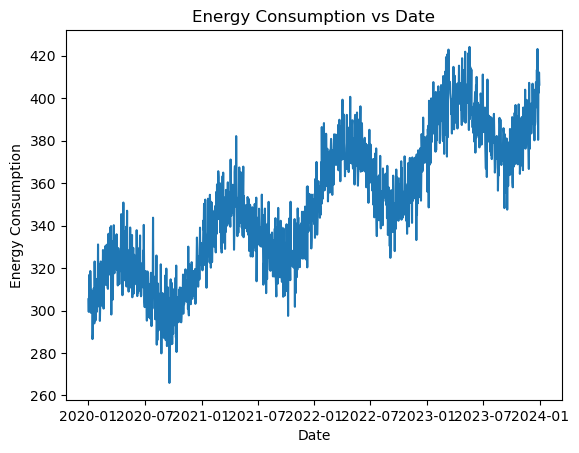

In [173]:

plt.plot(df['Date'], df['Energy Consumption'])
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption vs Date')
plt.show()

In [174]:
seasonal_consumption = df.groupby('Season')['Energy Consumption'].mean()
print(seasonal_consumption)

Season
Fall      340.465463
Spring    362.253085
Summer    347.041145
Winter    351.971706
Name: Energy Consumption, dtype: float64


In [175]:
weekday_consumption = df.groupby('Weekday')['Energy Consumption'].mean()
print(weekday_consumption)

Weekday
0    350.095751
1    351.346271
2    350.906694
3    350.468501
4    349.561613
5    351.328479
6    349.452565
Name: Energy Consumption, dtype: float64


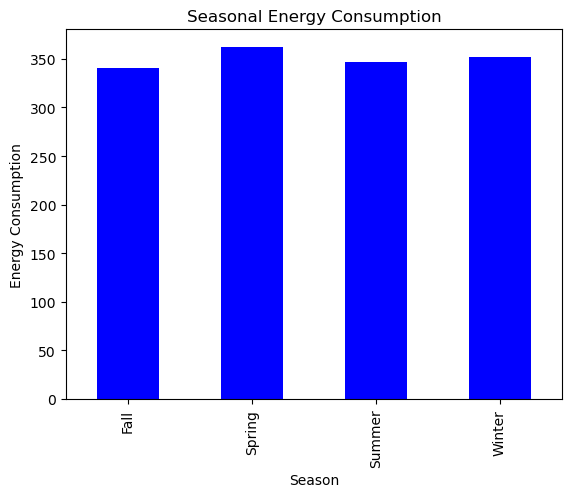

In [176]:
seasonal_consumption.plot(kind='bar',color='blue')
plt.xlabel('Season')
plt.ylabel('Energy Consumption')
plt.title('Seasonal Energy Consumption')
plt.show()

Plotting the 7day moving average vs daily consumption 

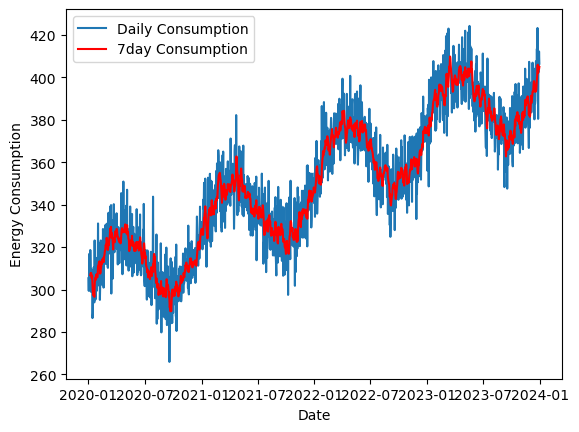

In [177]:
df['7 day Consumption']= df['Energy Consumption'].rolling(window=7).mean()
plt.plot(df['Date'],df['Energy Consumption'], label='Daily Consumption', )
plt.plot(df['Date'],df['7 day Consumption'],label='7day Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

273 is the average of the 

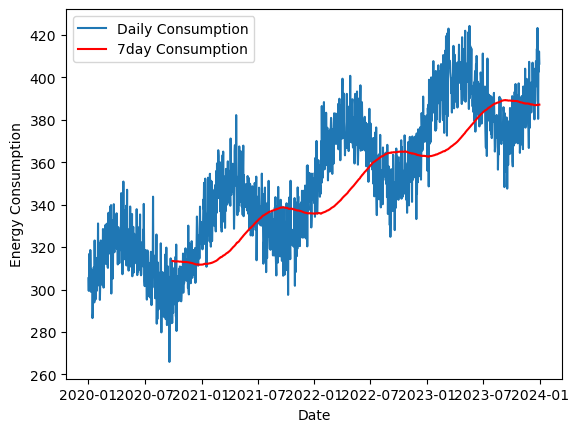

In [178]:
df['7 day Consumption']= df['Energy Consumption'].rolling(window=273).mean()
plt.plot(df['Date'],df['Energy Consumption'], label='Daily Consumption', )
plt.plot(df['Date'],df['7 day Consumption'],label='7day Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [179]:
df['Month'] = df['Date'].dt.month
df_consumption = df.groupby('Month')['Energy Consumption'].mean().reset_index()
df_consumption.columns = ['Month', 'Average Energy Consumption']

print(df_consumption)

    Month  Average Energy Consumption
0       1                  344.113029
1       2                  355.289326
2       3                  361.573121
3       4                  363.745319
4       5                  361.488953
5       6                  355.278048
6       7                  346.390618
7       8                  339.720476
8       9                  335.169267
9      10                  339.406751
10     11                  346.855662
11     12                  356.846379


In [180]:
import calendar
df_consumption['Month'] = df_consumption['Month'].apply(lambda x: calendar.month_name[x])

print(df_consumption)

        Month  Average Energy Consumption
0     January                  344.113029
1    February                  355.289326
2       March                  361.573121
3       April                  363.745319
4         May                  361.488953
5        June                  355.278048
6        July                  346.390618
7      August                  339.720476
8   September                  335.169267
9     October                  339.406751
10   November                  346.855662
11   December                  356.846379


In [181]:
df_consumption['Month'] = pd.Categorical(df_consumption['Month'], 
                                          categories=list(calendar.month_name)[1:], 
                                          ordered=True)
df_consumption = df_consumption.sort_values('Month')


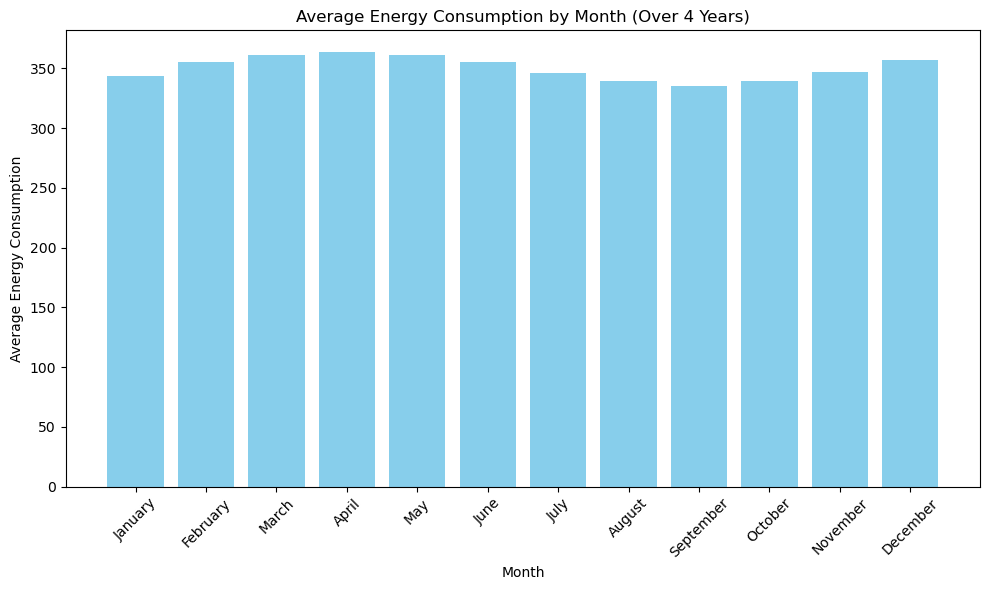

In [182]:

plt.figure(figsize=(10, 6))
plt.bar(df_consumption['Month'], df_consumption['Average Energy Consumption'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')
plt.title('Average Energy Consumption by Month (Over 4 Years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

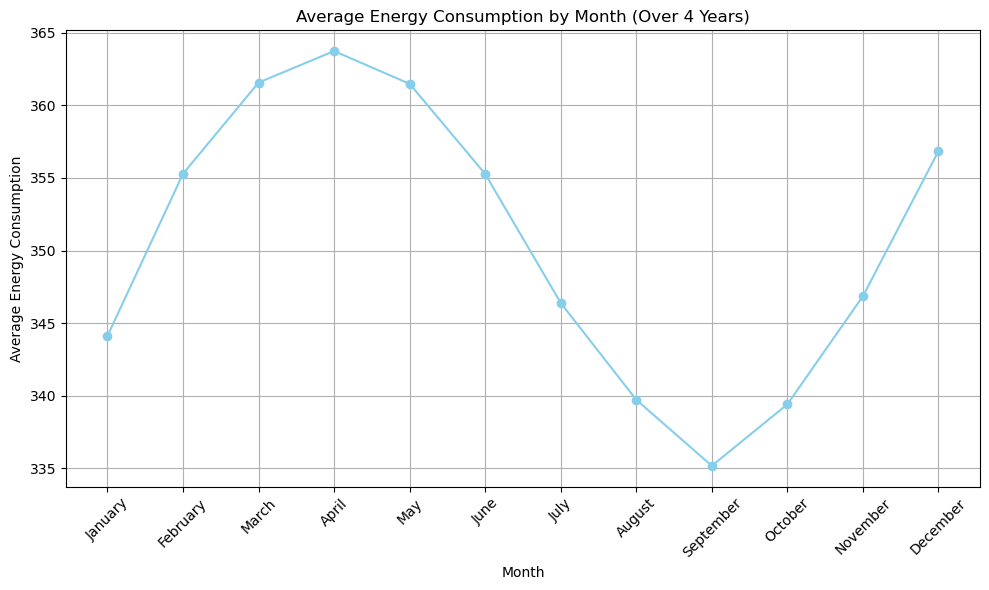

In [183]:
# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(df_consumption['Month'], df_consumption['Average Energy Consumption'], marker='o', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')
plt.title('Average Energy Consumption by Month (Over 4 Years)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

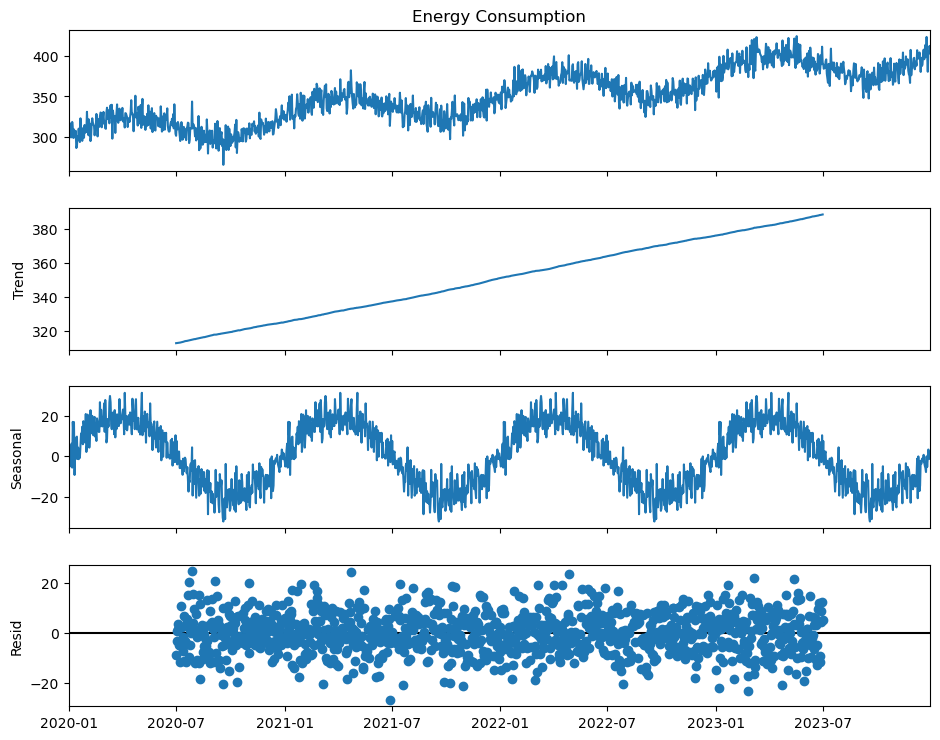

In [184]:
decomposition = sm.tsa.seasonal_decompose(df.set_index('Date')['Energy Consumption'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

        Date  Energy Consumption
0 2020-01-01          305.311409
1 2020-01-02          299.374329
2 2020-01-03          307.646359
3 2020-01-04          306.780983
4 2020-01-05          307.579311


/var/folders/fc/v3f9gj5x4yq0k95h5ldpprph0000gn/T/ipykernel_10451/2806950380.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Cleaned Energy Consumption': 'Energy Consumption'}, inplace=True)


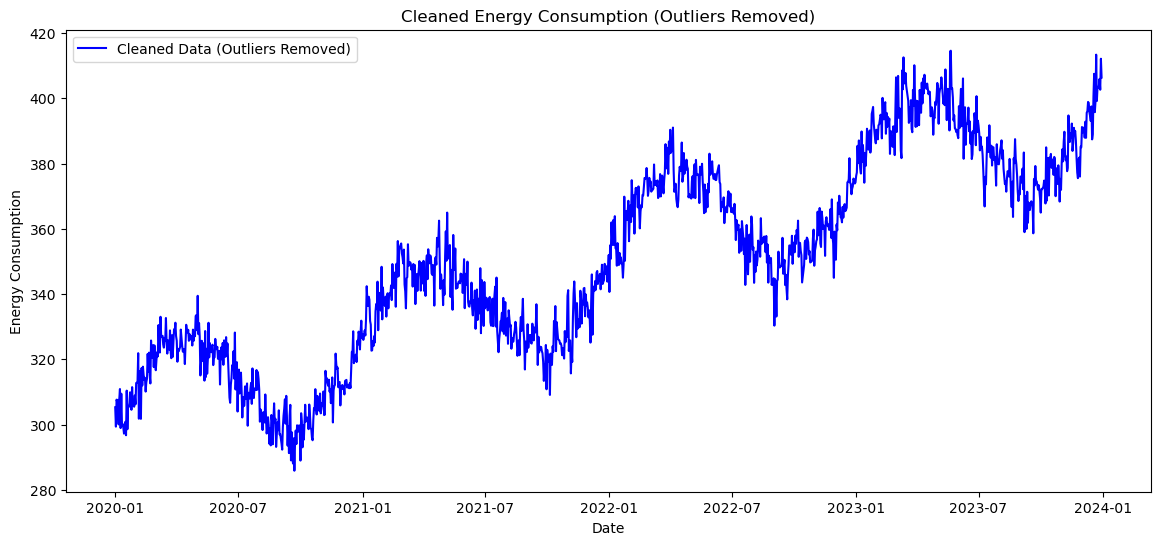

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def zscore(s, window, thresh=1, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['Cleaned Energy Consumption'] = zscore(df['Energy Consumption'], window=7)
df = df[['Date', 'Cleaned Energy Consumption']]
df.rename(columns={'Cleaned Energy Consumption': 'Energy Consumption'}, inplace=True)

print(df.head())

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Energy Consumption'], label='Cleaned Data (Outliers Removed)', color='blue')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Cleaned Energy Consumption (Outliers Removed)')
plt.legend()
plt.show()


# Normalization / LSTM Config  

In [201]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Energy Consumption'].values.reshape(-1, 1))


[[0.]]


In [187]:
data

array([[0.15107583],
       [0.10495639],
       [0.1692138 ],
       ...,
       [0.90714414],
       [0.9809284 ],
       [0.93623882]])

In [188]:
lookback = 15 
X, y = [], []

for i in range(len(data) - lookback):
    X.append(data[i:i + lookback])
    y.append(data[i + lookback])

X, y = np.array(X), np.array(y)



In [189]:
print(scaler.inverse_transform(X.reshape(-1, lookback)).reshape(-1, 1), scaler.inverse_transform(y).reshape(-1, 1))

[[305.31140865]
 [299.37432932]
 [307.64635892]
 ...
 [405.95174739]
 [402.64211031]
 [412.14055521]] [[300.8443893 ]
 [296.73797899]
 [310.40607945]
 ...
 [402.64211031]
 [412.14055521]
 [406.38754639]]


In [190]:
X = torch.FloatTensor(X).view(-1, lookback, 1) 
y = torch.FloatTensor(y)  

In [191]:
class EnergyLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=1):
        super(EnergyLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [192]:

input_size = 1
hidden_layer_size = 50
output_size = 1
num_layers = 3
model = EnergyLSTM(input_size, hidden_layer_size, output_size, num_layers)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train.view(-1, 1))
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test.view(-1, 1))
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

Epoch [10/100], Train Loss: 0.2265, Validation Loss: 0.2046
Epoch [20/100], Train Loss: 0.0908, Validation Loss: 0.0902
Epoch [30/100], Train Loss: 0.0573, Validation Loss: 0.0617
Epoch [40/100], Train Loss: 0.0446, Validation Loss: 0.0478
Epoch [50/100], Train Loss: 0.0374, Validation Loss: 0.0392
Epoch [60/100], Train Loss: 0.0206, Validation Loss: 0.0204
Epoch [70/100], Train Loss: 0.0042, Validation Loss: 0.0054
Epoch [80/100], Train Loss: 0.0040, Validation Loss: 0.0039
Epoch [90/100], Train Loss: 0.0035, Validation Loss: 0.0041
Epoch [100/100], Train Loss: 0.0028, Validation Loss: 0.0032


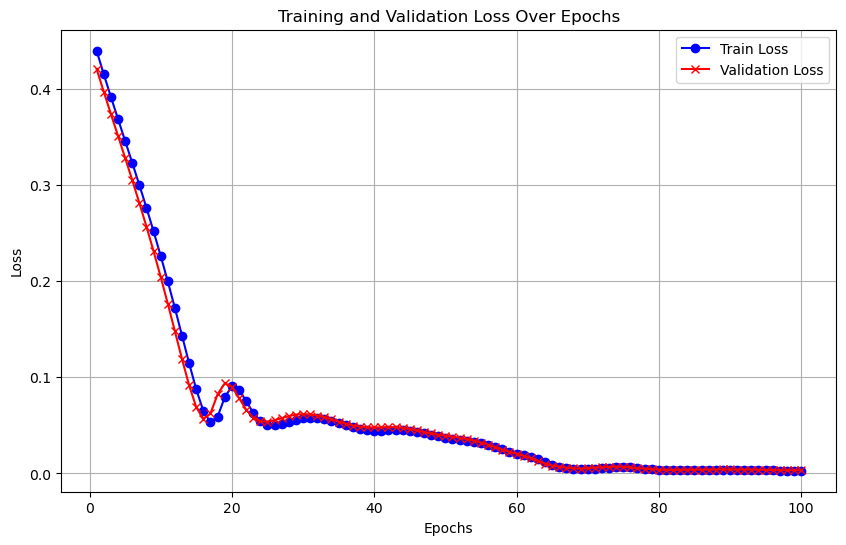

In [195]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Hidden Size: 10, Optimizer: Adam, Validation Loss: 0.051936425268650055
Hidden Size: 10, Optimizer: SGD, Validation Loss: 0.09109476953744888
Hidden Size: 10, Optimizer: RMSprop, Validation Loss: 0.0032735629938542843
Hidden Size: 50, Optimizer: Adam, Validation Loss: 0.0034952135756611824
Hidden Size: 50, Optimizer: SGD, Validation Loss: 0.1753266304731369
Hidden Size: 50, Optimizer: RMSprop, Validation Loss: 0.003687609452754259
Hidden Size: 100, Optimizer: Adam, Validation Loss: 0.002663322724401951
Hidden Size: 100, Optimizer: SGD, Validation Loss: 0.22232086956501007
Hidden Size: 100, Optimizer: RMSprop, Validation Loss: 0.0025897554587572813


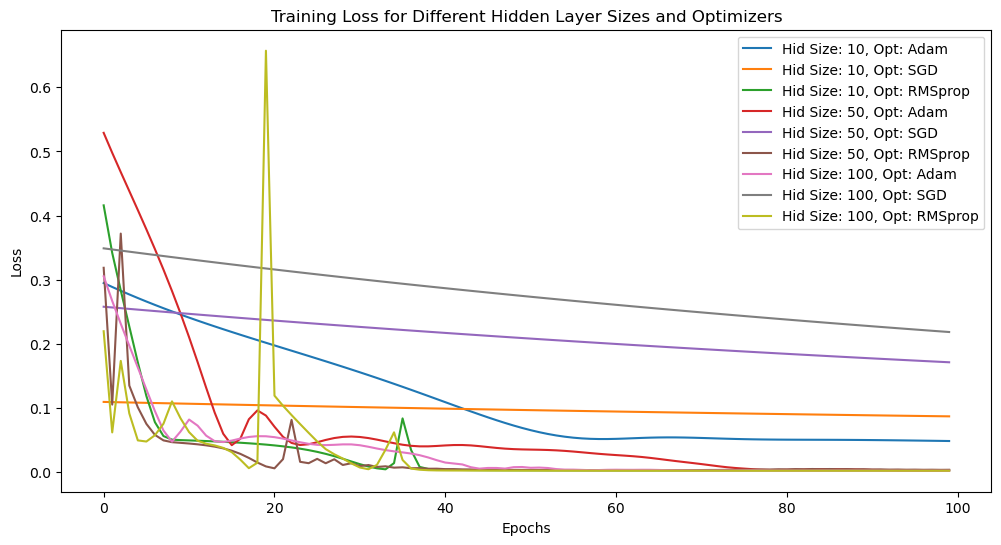

In [196]:
class EnergyLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(EnergyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out
hidden_layer_sizes = [10, 50, 100]
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}
num_layers = 3 
num_epochs = 100
learning_rate = 0.001
results = {}
for hidden_size in hidden_layer_sizes:
    for optimizer_name, optimizer_class in optimizers.items():
        model = EnergyLSTM(input_size=1, hidden_layer_size=hidden_size, output_size=1, num_layers=num_layers)
        criterion = nn.MSELoss()
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        losses = []
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            print(f'Hidden Size: {hidden_size}, Optimizer: {optimizer_name}, Validation Loss: {val_loss.item()}')
        results[(hidden_size, optimizer_name)] = losses
plt.figure(figsize=(12, 6))
for (hidden_size, optimizer_name), losses in results.items():
    plt.plot(losses, label=f'Hid Size: {hidden_size}, Opt: {optimizer_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Hidden Layer Sizes and Optimizers')
plt.legend()
plt.show()

/var/folders/fc/v3f9gj5x4yq0k95h5ldpprph0000gn/T/ipykernel_10451/2387688686.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fc/v3f9gj5x4yq0k95h5ldpprph0000gn/T/ipykernel_10451/2387688686.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


Epoch 99/100, Loss: 0.003786059794947505
Validation Loss: 0.003559768432751298
Test MSE: 0.003559768432751298, Test MAE: 0.04770904779434204, Test R²: 0.9377062320709229


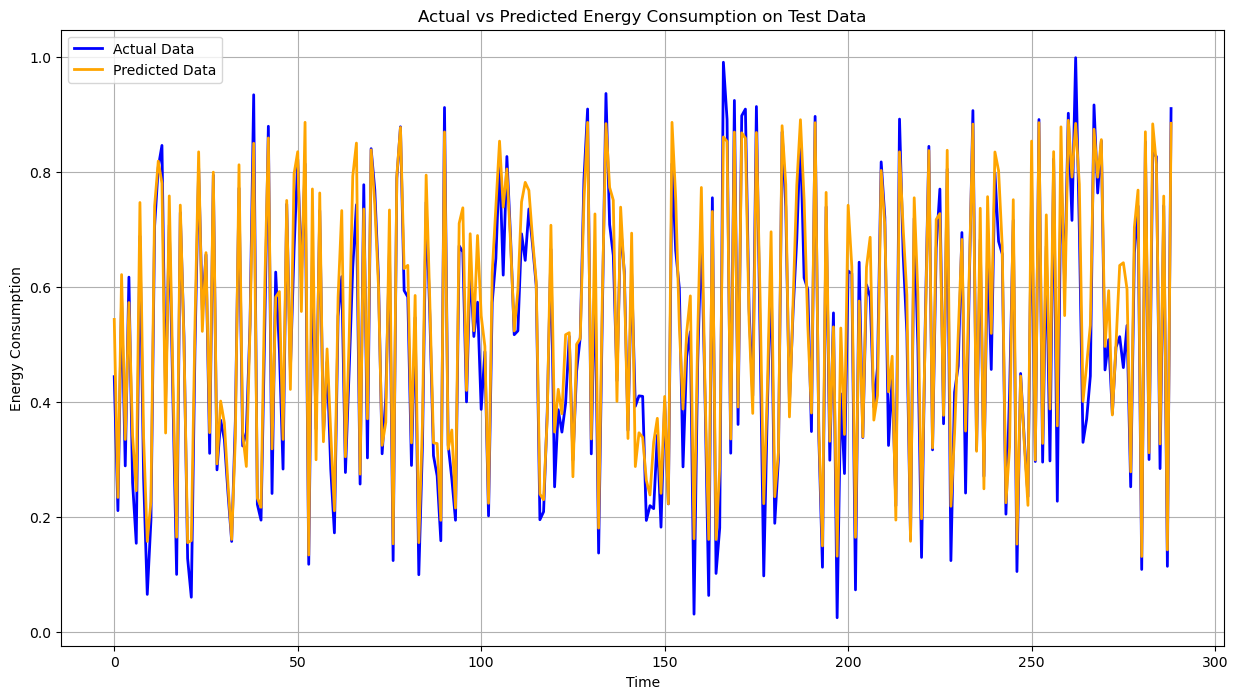

In [197]:
def mean_squared_error(pred, target):
    return torch.mean((pred - target) ** 2)
def mean_absolute_error(pred, target):
    return torch.mean(torch.abs(pred - target))

def r_squared(pred, target):
    ss_total = torch.sum((target - torch.mean(target)) ** 2)
    ss_residual = torch.sum((target - pred) ** 2)
    return 1 - (ss_residual / ss_total)
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch == num_epochs - 1:  
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    return losses
def validate_model(model, X_test, y_test, criterion):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
    return val_loss
def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_mse = mean_squared_error(test_outputs, y_test)
        test_mae = mean_absolute_error(test_outputs, y_test)
        test_r2 = r_squared(test_outputs, y_test) 
    return test_outputs, test_mse, test_mae, test_r2
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.numpy().reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.numpy().reshape(-1, 1))
input_size = 1 
hidden_size = 100  
optimizer_name = 'RMSprop' 
num_layers = 3  
num_epochs = 100
learning_rate = 0.001
model = EnergyLSTM(input_size=input_size, hidden_layer_size=hidden_size, output_size=1, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)  
losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs)
val_loss = validate_model(model, X_test_tensor, y_test_tensor, criterion)
print(f'Validation Loss: {val_loss.item()}')
test_predictions, test_mse, test_mae, test_r2 = test_model(model, X_test_tensor, y_test_tensor)
print(f'Test MSE: {test_mse.item()}, Test MAE: {test_mae.item()}, Test R²: {test_r2.item()}')
actuals = y_test_scaled.squeeze()  
predictions = test_predictions.squeeze().numpy()  
actuals_reverted = scaler.inverse_transform(actuals.reshape(-1, 1))
predictions_reverted = scaler.inverse_transform(predictions.reshape(-1, 1))

plt.figure(figsize=(15, 8))
plt.plot(actuals_reverted, label="Actual Data", color="blue", linewidth=2)
plt.plot(predictions_reverted, label="Predicted Data", color="orange", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption on Test Data")
plt.legend()
plt.grid()
plt.show()

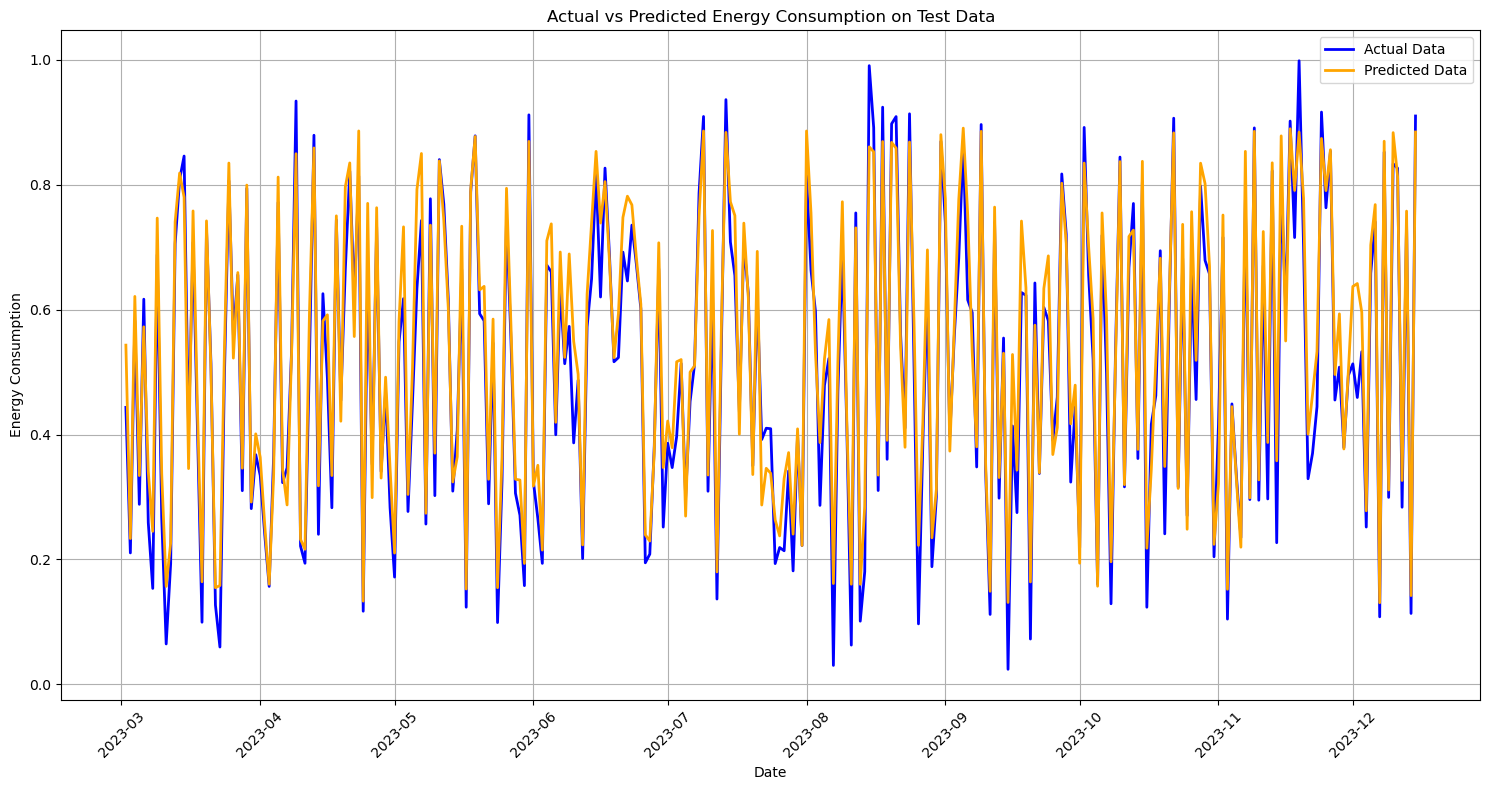

In [198]:
actuals = y_test_scaled.squeeze()  
predictions = test_predictions.squeeze().numpy()  
actuals_reverted = scaler.inverse_transform(actuals.reshape(-1, 1))
predictions_reverted = scaler.inverse_transform(predictions.reshape(-1, 1))

dates = df['Date'].iloc[len(X_train):len(X_train) + len(y_test)].values 

plt.figure(figsize=(15, 8))
plt.plot(dates, actuals_reverted, label="Actual Data", color="blue", linewidth=2)
plt.plot(dates, predictions_reverted, label="Predicted Data", color="orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption on Test Data")
plt.xticks(rotation=45)  
plt.legend()
plt.grid()
plt.tight_layout() 
plt.show()